<a href="https://colab.research.google.com/github/nair36/DeepLearning/blob/master/DeepLearning_Practico2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1>Práctico N° 2: Aprendizaje Profundo- Redes en escalera avanzadas</h1>


**Integrantes:** Johanna Frau, Sofía Luján y Nair Trógolo.




In [0]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow.keras import layers, models

In [0]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
!pip install mlflow

###Imports

In [0]:
import argparse
import matplotlib.pyplot as plt
import mlflow
import seaborn as sns
import nltk
import numpy as np
import os
import pandas as pd

from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType

from nltk import word_tokenize

from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout
#from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.utils import model_to_dot


from IPython.display import SVG
from gensim import corpora
from nltk.corpus import stopwords
from pprint import pprint

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from collections import Counter

from ast import literal_eval

nltk.download(["punkt", "stopwords"]);

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Dataset

#### Visualización de la distribución del target

In [0]:
dataset = pd.read_csv('https://raw.githubusercontent.com/jfrau/DiploDatos2019/master/data_petfinder/train.csv')
dataset.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,Description,AdoptionSpeed,PID
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,Nibble is a 3+ month old ball of cuteness. He ...,2,0
1,1,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,"Good guard dog, very alert, active, obedience ...",2,3
2,1,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,This handsome yet cute boy is up for adoption....,2,4
3,2,3,266,0,2,5,6,0,2,1,2,2,2,1,1,0,41326,This is a stray kitten that came to my house. ...,2,5
4,2,12,264,264,1,1,0,0,2,3,2,2,3,1,1,300,41326,anyone within the area of ipoh or taiping who ...,1,6


In [0]:
test_dataset = pd.read_csv('https://raw.githubusercontent.com/jfrau/DiploDatos2019/master/data_petfinder/test.csv')

In [0]:
dataset.shape

(10582, 20)

In [0]:
test_dataset.shape

(4411, 19)

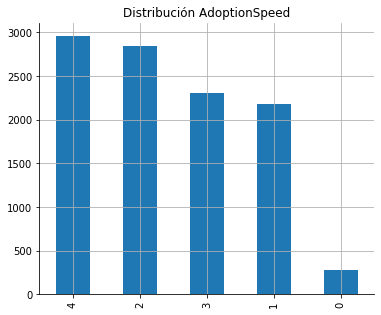

In [0]:
plt.figure(figsize=(6,5))
dataset['AdoptionSpeed'].value_counts(normalize=False,
                                       dropna=True,
                                       sort=True).plot(kind='bar',
                                                       grid=True)
plt.title('Distribución AdoptionSpeed')
sns.despine()

En el gráfico anterior observamos que todas las clases presentan una distribución similar salvo la clase 0, con lo cual nos encontramos frente a un claro problema de desbalanceo de clases con una clase minoritaria. Esto podría influir en el análisis de los resultados.

In [0]:
target_col = 'AdoptionSpeed'
nlabels = dataset[target_col].unique().shape[0]

#### Columnas con one_hot_enconding

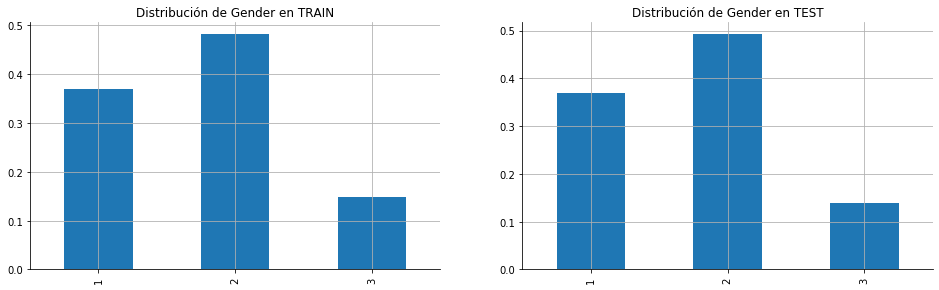

In [0]:
plt.figure(figsize=(25,10))
plt.subplot2grid((2,3),(0,0))
dataset['Gender'].value_counts(normalize=True,
                                       dropna=True,
                                       sort=False).plot(kind='bar',
                                                      grid=True)
plt.title('Distribución de Gender en TRAIN')
plt.subplot2grid((2,3),(0,1))
test_dataset['Gender'].value_counts(normalize=True,
                                       dropna=True,
                                       sort=False).plot(kind='bar',
                                                       grid=True)
plt.title('Distribución de Gender en TEST')
sns.despine()

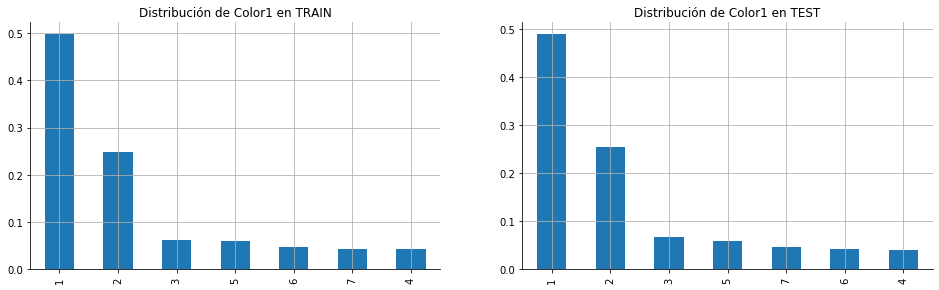

In [0]:
plt.figure(figsize=(25,10))
plt.subplot2grid((2,3),(0,0))
dataset['Color1'].value_counts(normalize=True,
                                       dropna=False,
                                       sort=True).plot(kind='bar',
                                                       grid=True)
plt.title('Distribución de Color1 en TRAIN')
plt.subplot2grid((2,3),(0,1))
test_dataset['Color1'].value_counts(normalize=True,
                                       dropna=True,
                                       sort=True).plot(kind='bar',
                                                       grid=True)
plt.title('Distribución de Color1 en TEST')
sns.despine()

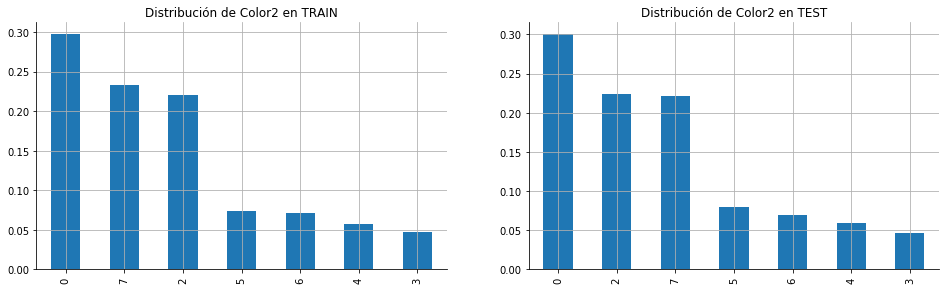

In [0]:
plt.figure(figsize=(25,10))
plt.subplot2grid((2,3),(0,0))
dataset['Color2'].value_counts(normalize=True,
                                       dropna=False,
                                       sort=True).plot(kind='bar',
                                                       grid=True)
plt.title('Distribución de Color2 en TRAIN')
plt.subplot2grid((2,3),(0,1))
test_dataset['Color2'].value_counts(normalize=True,
                                       dropna=True,
                                       sort=True).plot(kind='bar',
                                                       grid=True)
plt.title('Distribución de Color2 en TEST')
sns.despine()

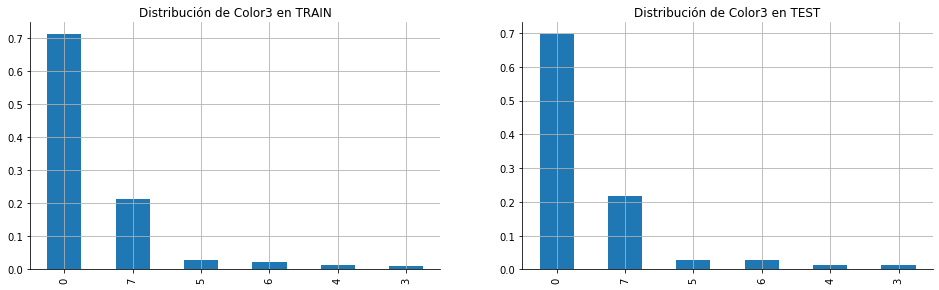

In [0]:
plt.figure(figsize=(25,10))
plt.subplot2grid((2,3),(0,0))
dataset['Color3'].value_counts(normalize=True,
                                       dropna=False,
                                       sort=True).plot(kind='bar',
                                                       grid=True)
plt.title('Distribución de Color3 en TRAIN')
plt.subplot2grid((2,3),(0,1))
test_dataset['Color3'].value_counts(normalize=True,
                                       dropna=True,
                                       sort=True).plot(kind='bar',
                                                       grid=True)
plt.title('Distribución de Color3 en TEST')
sns.despine()

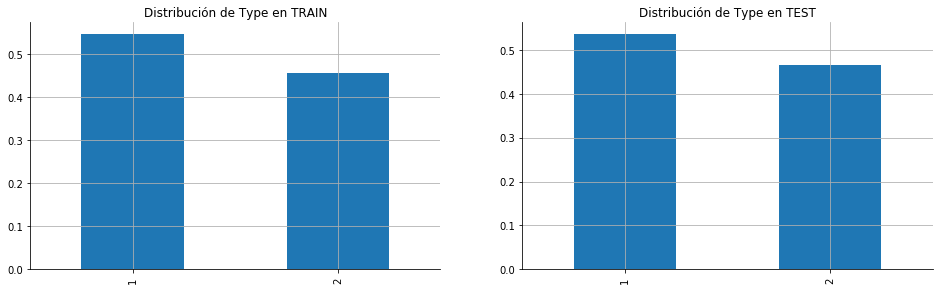

In [0]:
plt.figure(figsize=(25,10))
plt.subplot2grid((2,3),(0,0))
dataset['Type'].value_counts(normalize=True,
                                       dropna=False,
                                       sort=True).plot(kind='bar',
                                                       grid=True)
plt.title('Distribución de Type en TRAIN')
plt.subplot2grid((2,3),(0,1))
test_dataset['Type'].value_counts(normalize=True,
                                       dropna=True,
                                       sort=True).plot(kind='bar',
                                                       grid=True)
plt.title('Distribución de Type en TEST')
sns.despine()

## Funciones


In [0]:
full_history = {}

def save_history(model_name, history):
  dic = {}
  dic['val_accuracy'] = history.history['val_accuracy']
  dic['accuracy'] = history.history['accuracy']
  dic['loss'] = history.history['loss']
  dic['val_loss'] = history.history['val_loss']
  full_history[model_name] = dic

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++  

def get_mlflow_runs(query):
  all_experiments = [exp.experiment_id for exp in MlflowClient().list_experiments()]
  runs = MlflowClient().search_runs(all_experiments, query, ViewType.ALL)


  df = pd.DataFrame()
  for each in runs:
    dic = each.to_dictionary()
    metric = dic['data']['metrics']
    params = dic['data']['params']
    tags  = dic['data']['tags']
    info = dic['info']

    metric.update(params)
    metric.update(tags)
    metric.update(info)
    metric.pop('optimizer')

    for key,value in literal_eval(dic['data']['params']['optimizer']).items():
      metric['optimizer_'+key] = value
    
    df = df.append(pd.DataFrame([metric]))

  return df

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

def process_features(df, one_hot_columns, numeric_columns, embedded_columns, test=False):
    
    direct_features = []

    # Create one hot encodings
    for one_hot_col, max_value in one_hot_columns.items():
        direct_features.append(tf.keras.utils.to_categorical(df[one_hot_col] - 1, max_value))

    # TODO Create and append numeric columns
    # Don't forget to normalize!
    scaler = MinMaxScaler()
    direct_features.append(scaler.fit_transform(df[numeric_columns]))
    
    
    # Concatenate all features that don't need further embedding into a single matrix.
    features = {'direct_features': np.hstack(direct_features)}

    # Create embedding columns - nothing to do here. We will use the zero embedding for OOV
    for embedded_col in embedded_columns.keys():
       features[embedded_col] = df[embedded_col].values

    if not test:
        nlabels = df[TARGET_COL].unique().shape[0]
        # Convert labels to one-hot encodings
        targets = tf.keras.utils.to_categorical(df[TARGET_COL], nlabels)
    else:
        targets = None
    
    return features, targets


#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
def load_dataset():

    # Read train dataset (and maybe dev, if you need to...)
    dataset, dev_dataset = train_test_split(
        pd.read_csv('https://raw.githubusercontent.com/jfrau/DiploDatos2019/master/data_petfinder/train.csv'), 
        test_size=0.2)
    test_dataset = pd.read_csv('https://raw.githubusercontent.com/jfrau/DiploDatos2019/master/data_petfinder/test.csv')
    
    print('Training samples {}, test_samples {}'.format(
        dataset.shape[0], test_dataset.shape[0]))
    
    return dataset, dev_dataset, test_dataset

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
def build_model(args, nlabels, direct_features_input_shape, embedded_columns):

    embedding_layers = []
    inputs = []

    for embedded_col, max_value in embedded_columns.items():
        input_layer = layers.Input(shape=(1,), name=embedded_col)
        inputs.append(input_layer)
        # Define the embedding layer
        embedding_size = int(max_value / 4)
        embedding_layers.append(
            tf.squeeze(layers.Embedding(input_dim=max_value, 
                                        output_dim=embedding_size)(input_layer), 
                                        axis=-2))
        print('Adding embedding of size {} for layer {}'.format(embedding_size,
                                                                  embedded_col))

    # Add the direct features already calculated
    direct_features_input = layers.Input(shape=direct_features_input_shape, 
                            name='direct_features')
    inputs.append(direct_features_input)
        
    # Concatenate everything together
    features = layers.concatenate(embedding_layers + [direct_features_input])
    
    #-------> DE AQUI PARA ABAJO ESTA DIFUSO
    convolucional1 = layers.Conv2D(filters=32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape)
    dropout1 = layers.Dropout(0.25)(convolucional1)
    #maxpooling
    #flatten
    dense2 = layers.Dense(128, activation='relu')(dropout1)
    dropout2 = layers.Dropout(0.5)(dense2)

    output_layer = layers.Dense(nlabels, activation='softmax')(dropout2)

    model = models.Model(inputs=inputs, outputs=output_layer)

    return model

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

SW = set(stopwords.words("english"))

def tokenize_description(description):
    return [w.lower() for w in word_tokenize(description, language="english") 
            if w.lower() not in SW]

#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

### Tokenizacion de la columna de descripciones

In [0]:
SW = set(stopwords.words("english"))

In [0]:
SW #stops words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [0]:
# Fill the null values with the empty string to avoid errors with NLTK tokenization
dataset["TokenizedDescription"] = dataset["Description"].fillna(value="").apply(tokenize_description)

**Descripción original vs. Descripción tokenizada**

In [0]:
dataset['Description'] #original description

0        Nibble is a 3+ month old ball of cuteness. He ...
1        Good guard dog, very alert, active, obedience ...
2        This handsome yet cute boy is up for adoption....
3        This is a stray kitten that came to my house. ...
4        anyone within the area of ipoh or taiping who ...
                               ...                        
10577    He is very intelligent and cute. Fluffy and lo...
10578    been at my place for a while..am hoping to fin...
10579    I have 4 kittens that need to be adopt urgentl...
10580    she is very shy..adventures and independent..s...
10581    Fili just loves laying around and also loves b...
Name: Description, Length: 10582, dtype: object

In [0]:
dataset['TokenizedDescription'] #tokenized description

0        [nibble, 3+, month, old, ball, cuteness, ., en...
1        [good, guard, dog, ,, alert, ,, active, ,, obe...
2        [handsome, yet, cute, boy, adoption, ., playfu...
3        [stray, kitten, came, house, ., feeding, ,, ke...
4        [anyone, within, area, ipoh, taiping, interest...
                               ...                        
10577    [intelligent, cute, ., fluffy, looks, much, be...
10578         [place, while..am, hoping, find, good, home]
10579    [4, kittens, need, adopt, urgently, ., 1, 1/2,...
10580    [shy..adventures, independent..she, hates, cag...
10581    [fili, loves, laying, around, also, loves, sun...
Name: TokenizedDescription, Length: 10582, dtype: object

### Tamaño de las descripciones

In [0]:
pprint(dataset["TokenizedDescription"].apply(len).describe())

count    10582.000000
mean        44.418541
std         48.464623
min          0.000000
25%         16.000000
50%         31.000000
75%         55.000000
max        803.000000
Name: TokenizedDescription, dtype: float64


In [0]:
MAX_SEQUENCE_LEN = 55

### Generación del vocabulario

In [0]:
vocabulary = corpora.Dictionary(dataset["TokenizedDescription"])
vocabulary.filter_extremes(no_below=1, no_above=1.0, keep_n=10000)

In [0]:
len(vocabulary)

10000

 **Word embedding (GloVe)**

In [0]:
 #download pretrained GloVe embeddings
#!wget https://cs.famaf.unc.edu.ar/~ccardellino/resources/diplodatos/glove.6B.zip

--2019-11-23 17:49:23--  https://cs.famaf.unc.edu.ar/~ccardellino/resources/diplodatos/glove.6B.zip
Resolving cs.famaf.unc.edu.ar (cs.famaf.unc.edu.ar)... 200.16.17.55
Connecting to cs.famaf.unc.edu.ar (cs.famaf.unc.edu.ar)|200.16.17.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

glove.6B.zip.2       37%[======>             ] 306.76M  17.9MB/s    eta 31s    ^C


In [0]:
#!unzip glove.6B.zip

In [0]:
#glove_dir = './'


In [0]:
embeddings_index = {}

with open("./glove.6B.100d.txt", "r") as fh:
    for line in fh:
        values = line.split()
        word = values[0]
        if word in vocabulary.token2id:  # Only use the embeddings of words in our vocabulary
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

print("Found {} word vectors.".format(len(embeddings_index)))

Found 7897 word vectors.


### Generación del dataset

In [0]:
# +++++++++ one_hot_columns +++++++++++++++++++++++
one_hot_columns = {one_hot_col: dataset[one_hot_col].max()
    for one_hot_col in ['Gender', 'Color1','Color2', 'Color3', 'Type']
    }
    
    #++++++++++  embedded_columns +++++++++++++++++++++
embedded_columns = {
        embedded_col: dataset[embedded_col].max() + 1 for embedded_col in ['Breed1','Breed2']
    }
    
    #++++++++++ numeric_columns ++++++++++++++++++++++++
numeric_columns = ['Age', 'Fee']
for num_column in numeric_columns:
  dataset[num_column] = MinMaxScaler().fit_transform(dataset[[num_column]].values)

In [0]:
print(one_hot_columns)

{'Gender': 3, 'Color1': 7, 'Color2': 7, 'Color3': 7, 'Type': 2}


In [0]:
print(embedded_columns)

{'Breed1': 308, 'Breed2': 308}


In [0]:
def dataset_generator(ds, test_data=False):
  
    for _, row in ds.iterrows():
        instance = {}
        direct_features =[]
        
        # One hot encoded features
        #instance["direct_features"] = np.hstack([
        #    tf.keras.utils.to_categorical(row[one_hot_col] - 1, max_value)
        #    for one_hot_col, max_value in one_hot_columns.items()
        #])
        for one_hot_col, max_value in one_hot_columns.items():
          direct_features.append(tf.keras.utils.to_categorical(row[one_hot_col] - 1, max_value))

        # Numeric features (should be normalized beforehand)
        # TODO: Add numeric features for row
        direct_features.append(row[numeric_columns])

        # One hot encoded features
        instance["direct_features"] =  np.hstack(direct_features)      
        
        # Embedded features
        for embedded_col in embedded_columns:
            instance[embedded_col] = [row[embedded_col]]
        
        # Document to indices for text data, truncated at MAX_SEQUENCE_LEN words
        instance["description"] = vocabulary.doc2idx(
            row["TokenizedDescription"],
            unknown_word_index=len(vocabulary)
        )[:MAX_SEQUENCE_LEN]
        
        # One hot encoded target for categorical crossentropy
        if not test_data:
            target = tf.keras.utils.to_categorical(row[target_col], nlabels)
            yield instance, target
        else:
            yield instance

In [0]:
# Set output types of the generator (for numeric types check the type is valid)
instance_types = {
    "direct_features": tf.float32,
    "description": tf.int32
}

for embedded_col in embedded_columns:
    instance_types[embedded_col] = tf.int32
        
tf_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(dataset),
    output_types=(instance_types, tf.int32)
)

for data, target in tf_dataset.take(2):
    pprint(data)
    pprint(target)
    print()


{'Breed1': <tf.Tensor: id=7016, shape=(1,), dtype=int32, numpy=array([299], dtype=int32)>,
 'Breed2': <tf.Tensor: id=7017, shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'description': <tf.Tensor: id=7018, shape=(42,), dtype=int32, numpy=
array([23,  2, 20, 24,  4, 10,  1, 11, 26,  1, 27,  9,  6, 21,  3,  8, 15,
       22, 33,  7, 13, 30,  1, 29, 18, 17,  1, 12, 31, 14,  5,  6, 16,  1,
       19, 28, 25, 32, 23,  0,  5,  1], dtype=int32)>,
 'direct_features': <tf.Tensor: id=7019, shape=(28,), dtype=float32, numpy=
array([1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       1.        , 0.01176471, 0.03333334], dtype=float32)>}
<tf.Tensor: id=7020, shape=(5,), dtype=int32, numpy=array([0, 0, 1, 0, 0]

In [0]:
TRAIN_SIZE = int(dataset.shape[0] * 0.8)
DEV_SIZE = dataset.shape[0] - TRAIN_SIZE
BATCH_SIZE = 128

shuffled_dataset = tf_dataset.shuffle(TRAIN_SIZE + DEV_SIZE, seed=42)

# Pad the datasets to the max value for all the "non sequence" features
padding_shapes = (
    {k: [-1] for k in ["direct_features"] + list(embedded_columns.keys())},
    [-1]
)

# Pad to MAX_SEQUENCE_LEN for sequence features
padding_shapes[0]["description"] = [MAX_SEQUENCE_LEN]

# Pad values are irrelevant for non padded data
padding_values = (
    {k: 0 for k in list(embedded_columns.keys())},
    0
)

# Padding value for direct features should be a float
padding_values[0]["direct_features"] = np.float32(0)

# Padding value for sequential features is the vocabulary length + 1
padding_values[0]["description"] = len(vocabulary) + 1

train_dataset = shuffled_dataset.skip(DEV_SIZE)\
    .padded_batch(BATCH_SIZE, padded_shapes=padding_shapes, padding_values=padding_values)

dev_dataset = shuffled_dataset.take(DEV_SIZE)\
    .padded_batch(BATCH_SIZE, padded_shapes=padding_shapes, padding_values=padding_values)

### Matriz de embeddings de palabras

In [0]:
len(vocabulary) + 2

10002

In [0]:
EMBEDDINGS_DIM = 100  # Given by the model (in this case glove.6B.100d)

embedding_matrix = np.zeros((len(vocabulary) + 2, 100))

for widx, word in vocabulary.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[widx] = embedding_vector
    else:
        # Random normal initialization for words without embeddings
        embedding_matrix[widx] = np.random.normal(size=(100,))  

# Random normal initialization for unknown words
embedding_matrix[len(vocabulary)] = np.random.normal(size=(100,))

### Definiendo los inputs del modelo

In [0]:
tf.keras.backend.clear_session()

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = tf.keras.layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(
            tf.keras.layers.Embedding(
                input_dim=max_value, 
                output_dim=embedding_size
            )(input_layer), 
            axis=-2
        )
    )
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = tf.keras.layers.Input(
    shape=(sum(one_hot_columns.values())+len(numeric_columns),), 
    name='direct_features'
)
inputs.append(direct_features_input)

# Word embedding layer
description_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LEN,), name="description")
inputs.append(description_input)

word_embeddings_layer = tf.keras.layers.Embedding(
    embedding_matrix.shape[0],
    EMBEDDINGS_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LEN,
    trainable=False,
    name="word_embedding"
)(description_input)

Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2


### Definiendo la red que trabajará con el texto

## Modelo 1

In [0]:
## TODO: Create a NN (CNN or RNN) for the description input (replace the next)
DESCRIPTION_FEATURES_LAYER_SIZE = 512

description_features = tf.keras.layers.SimpleRNN(256)(word_embeddings_layer)
description_features = tf.keras.layers.Flatten()(description_features)  # This is a simple concatenation
description_features = tf.keras.layers.Dense(
    units=DESCRIPTION_FEATURES_LAYER_SIZE, 
    activation="relu", 
    name="description_features")(description_features)

In [0]:
HIDDEN_LAYER_SIZE = 128

feature_map = tf.keras.layers.Concatenate(name="feature_map")(
    embedding_layers + [description_features, direct_features_input]
)

hidden_layer = tf.keras.layers.Dense(HIDDEN_LAYER_SIZE, activation="relu")(feature_map)
output_layer = tf.keras.layers.Dense(nlabels, activation="softmax", name="output")(hidden_layer)

model = tf.keras.models.Model(inputs=inputs, outputs=[output_layer], name="amazing_model")

In [0]:
model.compile(loss='categorical_crossentropy', 
              optimizer='nadam',
              metrics=['accuracy'])
model.summary()

Model: "amazing_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 55, 100)      1000200     description[0][0]                
__________________________________________________________________________________________________
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Breed2 (InputLayer)             [(None, 1)]          0                                            
______________________________________________________________________________________

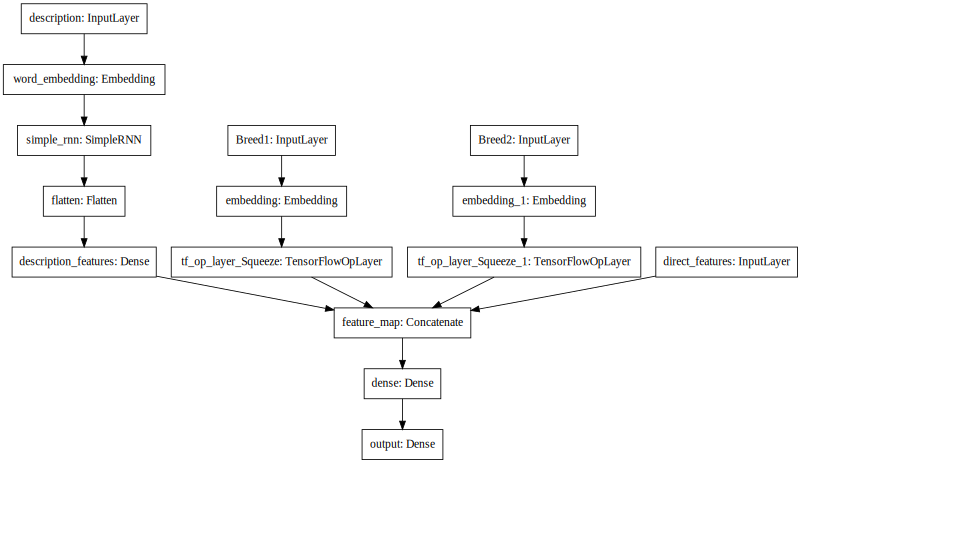

In [0]:
SVG(tf.keras.utils.model_to_dot(model, dpi=60).create(prog='dot', format='svg'))

In [0]:
with mlflow.start_run(nested=True):
      # Log model hiperparameters first
      mlflow.set_tag('ejercicio', '1') 
      mlflow.log_param('description_features_layer_size', DESCRIPTION_FEATURES_LAYER_SIZE)
      mlflow.log_param('hidden_layer_size', HIDDEN_LAYER_SIZE)
      mlflow.log_param('embedded_columns', embedded_columns)
      mlflow.log_param('one_hot_columns', one_hot_columns)
      mlflow.log_param('numerical_columns', numeric_columns)  # Not using these yet
            
      epochs = 10
      history = model.fit(train_dataset, epochs=epochs, validation_data=dev_dataset,
                          verbose=1)
    
      # TODO: analyze history to see if model converges/overfits
      print(history)
      loss, accuracy = 0, 0
      
      loss, accuracy = model.evaluate(dev_dataset, verbose=0)
      print("*** Dev loss: {} - accuracy: {}".format(loss, accuracy))
      mlflow.log_metric('dev-loss', loss)
      mlflow.log_metric('dev-accuracy', accuracy)

      loss, accuracy = model.evaluate(train_dataset, verbose=0)
      print("*** Train loss: {} - accuracy: {}".format(loss, accuracy))
      mlflow.log_metric('train-loss', loss)
      mlflow.log_metric('train-accuracy', accuracy)

      save_history('1', history)



Epoch 1/10
67/67 [==============================] - 35s 516ms/step - loss: 1.4060 - accuracy: 0.3471 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
67/67 [==============================] - 34s 512ms/step - loss: 1.3756 - accuracy: 0.3613 - val_loss: 1.3720 - val_accuracy: 0.3732
Epoch 3/10
67/67 [==============================] - 34s 512ms/step - loss: 1.3634 - accuracy: 0.3689 - val_loss: 1.4509 - val_accuracy: 0.3623
Epoch 4/10
67/67 [==============================] - 34s 513ms/step - loss: 1.3580 - accuracy: 0.3858 - val_loss: 1.3343 - val_accuracy: 0.3793
Epoch 5/10
67/67 [==============================] - 35s 521ms/step - loss: 1.3569 - accuracy: 0.3735 - val_loss: 1.3638 - val_accuracy: 0.3618
Epoch 6/10
67/67 [==============================] - 35s 517ms/step - loss: 1.3390 - accuracy: 0.3956 - val_loss: 1.3518 - val_accuracy: 0.3680
Epoch 7/10
67/67 [==============================] - 34s 512ms/step - loss: 1.3235 - accuracy: 0.4031 - val_loss: 1.3105 - val_accuracy

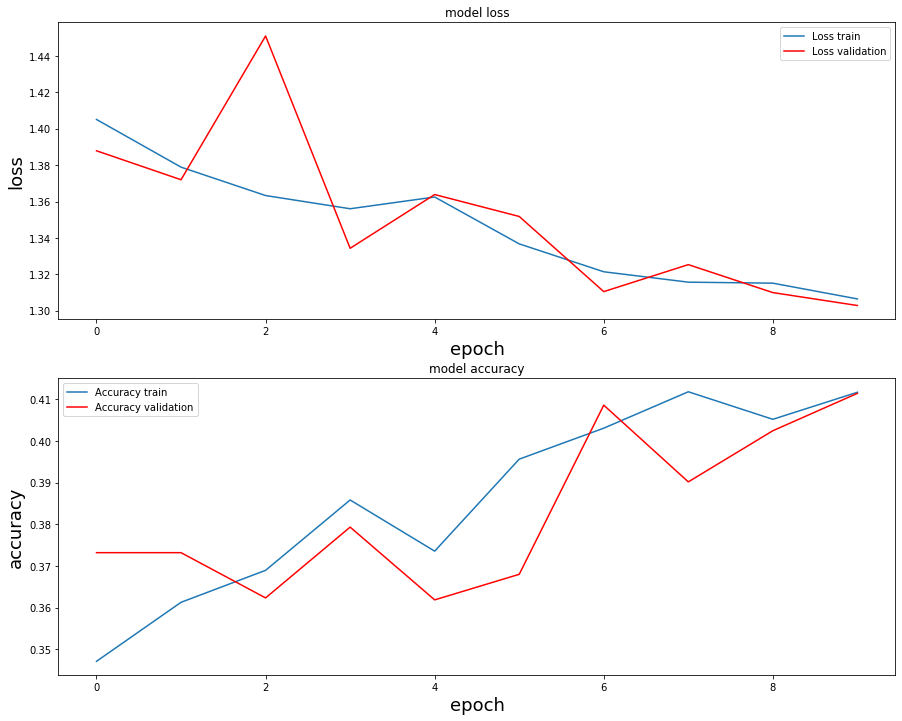

In [0]:
plt.figure(figsize=(15,12))
        
plt.subplot(2,1,1)
plt.plot(history.history['loss'], label='Loss train')
plt.plot(history.history['val_loss'], color='red', label='Loss validation')
plt.title('model loss')
plt.ylabel('loss', size='18')
plt.xlabel('epoch', size='18')
plt.legend()
        
plt.subplot(2,1,2)
plt.plot(history.history['accuracy'], label='Accuracy train')
plt.plot(history.history['val_accuracy'], color='red', label='Accuracy validation')
plt.title('model accuracy')
plt.ylabel('accuracy', size='18')
plt.xlabel('epoch',size='18')
plt.legend()
plt.show()

##Modelo 2

In [0]:
## TODO: Create a NN (CNN or RNN) for the description input (replace the next)
DESCRIPTION_FEATURES_LAYER_SIZE = 512

description_features = tf.keras.layers.SimpleRNN(256)(word_embeddings_layer)
dropout1 =tf.keras.layers.Dropout(0.25)(description_features)

flatten1 = tf.keras.layers.Flatten()(dropout1)  # This is a simple concatenation
description_features = tf.keras.layers.Dense(
    units=200, 
    activation="relu", 
    name="description_features")(flatten1)



In [0]:
HIDDEN_LAYER_SIZE = 128

feature_map = tf.keras.layers.Concatenate(name="feature_map")(
    embedding_layers + [description_features, direct_features_input]
)

#lstm_layer = tf.keras.layers.LSTM(4,return_sequences = True)(feature_map)
#x = tf.keras.layers.Dropout(DESCRIPTION_FEATURES_DROPOUT1)(lstm_layer) 
hidden_layer = tf.keras.layers.Dense(HIDDEN_LAYER_SIZE, activation="relu")(feature_map)
output_layer = tf.keras.layers.Dense(nlabels, activation="softmax", name="output")(hidden_layer)

model = tf.keras.models.Model(inputs=inputs, outputs=[output_layer], name="amazing_model")

In [0]:
model.compile(loss='categorical_crossentropy', 
              optimizer='nadam',
              metrics=['accuracy'])
model.summary()

Model: "amazing_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 55, 100)      1000200     description[0][0]                
__________________________________________________________________________________________________
simple_rnn_18 (SimpleRNN)       (None, 256)          91392       word_embedding[0][0]             
__________________________________________________________________________________________________
Breed1 (InputLayer)             [(None, 1)]          0                                            
______________________________________________________________________________________

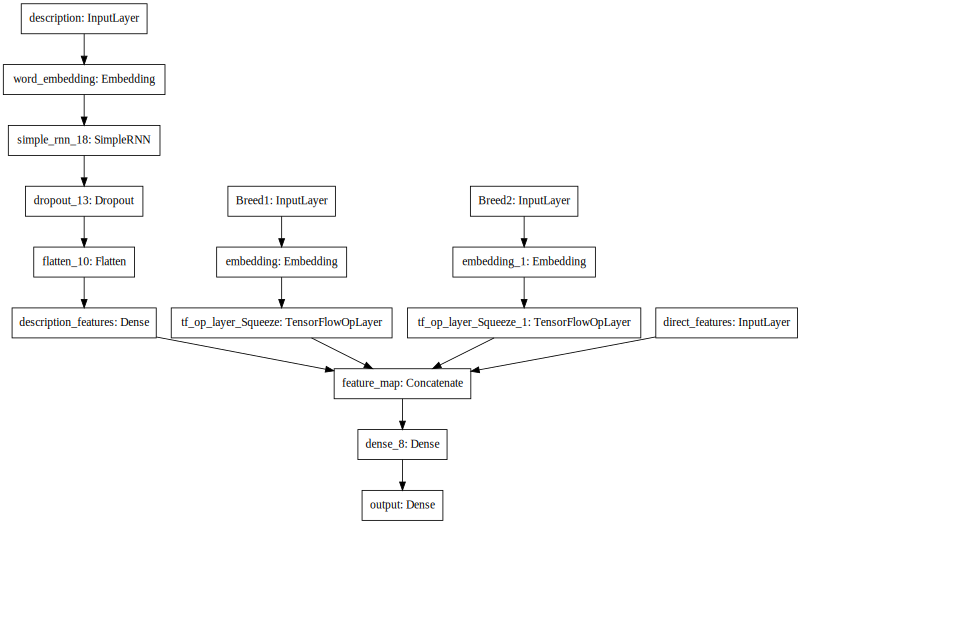

In [0]:
SVG(tf.keras.utils.model_to_dot(model, dpi=60).create(prog='dot', format='svg'))

In [0]:
with mlflow.start_run(nested=True):
      # Log model hiperparameters first
      mlflow.set_tag('ejercicio', '1') 
      mlflow.log_param('description_features_layer_size', DESCRIPTION_FEATURES_LAYER_SIZE)
      mlflow.log_param('hidden_layer_size', HIDDEN_LAYER_SIZE)
      mlflow.log_param('embedded_columns', embedded_columns)
      mlflow.log_param('one_hot_columns', one_hot_columns)
      mlflow.log_param('numerical_columns', numeric_columns)  # Not using these yet
            
      epochs = 10
      history = model.fit(train_dataset, epochs=epochs, validation_data=dev_dataset,
                          verbose=1)
    
      # TODO: analyze history to see if model converges/overfits
      print(history)
      loss, accuracy = 0, 0
      
      loss, accuracy = model.evaluate(dev_dataset, verbose=0)
      print("*** Dev loss: {} - accuracy: {}".format(loss, accuracy))
      mlflow.log_metric('dev-loss', loss)
      mlflow.log_metric('dev-accuracy', accuracy)

      loss, accuracy = model.evaluate(train_dataset, verbose=0)
      print("*** Train loss: {} - accuracy: {}".format(loss, accuracy))
      mlflow.log_metric('train-loss', loss)
      mlflow.log_metric('train-accuracy', accuracy)

      save_history('1', history)



Epoch 1/10
67/67 [==============================] - 38s 563ms/step - loss: 1.4641 - accuracy: 0.2918 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
67/67 [==============================] - 35s 525ms/step - loss: 1.4613 - accuracy: 0.3081 - val_loss: 1.5259 - val_accuracy: 0.2829
Epoch 3/10
67/67 [==============================] - 35s 521ms/step - loss: 1.4408 - accuracy: 0.3269 - val_loss: 1.5510 - val_accuracy: 0.2735
Epoch 4/10
67/67 [==============================] - 35s 521ms/step - loss: 1.4192 - accuracy: 0.3364 - val_loss: 1.4464 - val_accuracy: 0.3132
Epoch 5/10
67/67 [==============================] - 35s 521ms/step - loss: 1.4110 - accuracy: 0.3427 - val_loss: 1.4226 - val_accuracy: 0.3245
Epoch 6/10
67/67 [==============================] - 35s 528ms/step - loss: 1.4093 - accuracy: 0.3379 - val_loss: 1.3956 - val_accuracy: 0.3642
Epoch 7/10
67/67 [==============================] - 35s 523ms/step - loss: 1.4007 - accuracy: 0.3485 - val_loss: 1.3967 - val_accuracy

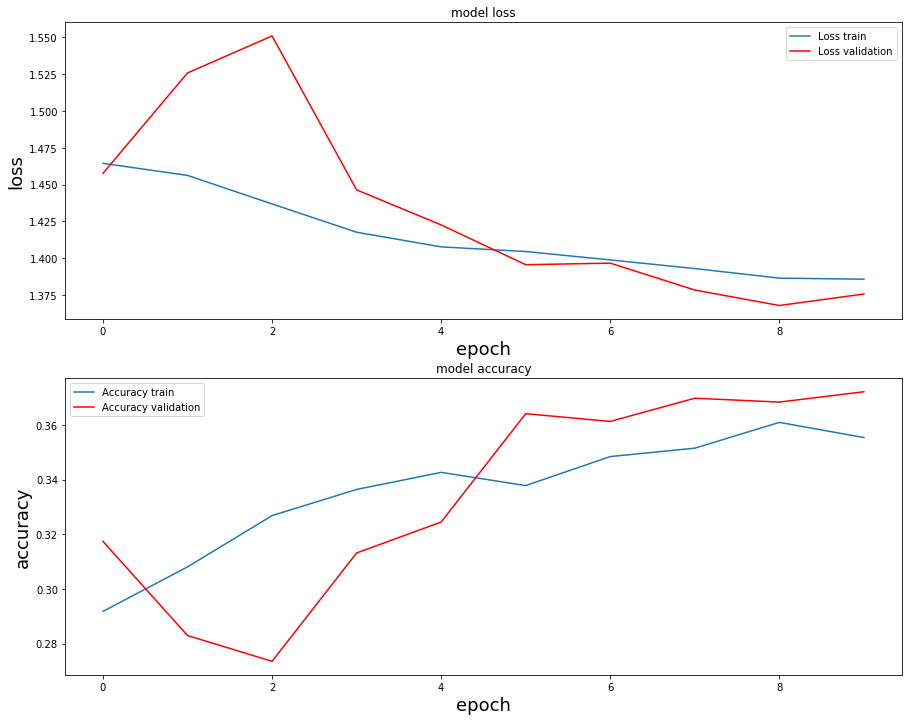

In [0]:
plt.figure(figsize=(15,12))
        
plt.subplot(2,1,1)
plt.plot(history.history['loss'], label='Loss train')
plt.plot(history.history['val_loss'], color='red', label='Loss validation')
plt.title('model loss')
plt.ylabel('loss', size='18')
plt.xlabel('epoch', size='18')
plt.legend()
        
plt.subplot(2,1,2)
plt.plot(history.history['accuracy'], label='Accuracy train')
plt.plot(history.history['val_accuracy'], color='red', label='Accuracy validation')
plt.title('model accuracy')
plt.ylabel('accuracy', size='18')
plt.xlabel('epoch',size='18')
plt.legend()
plt.show()

## Modelo 3


In [0]:
DESCRIPTION_FEATURES_LAYER_SIZE = 512
FILTER_WIDTHS = [5, 10, 15]  
FILTER_COUNT = 64
 
conv_layers = []
for filter_width in FILTER_WIDTHS:
    layer = tf.keras.layers.Conv1D(
        FILTER_COUNT,
        filter_width,
        activation="relu",
        name="conv_{}_words".format(filter_width)
    )(word_embeddings_layer)
    layer = tf.keras.layers.GlobalMaxPooling1D(name="max_pool_{}_words".format(filter_width))(layer)
    conv_layers.append(layer)

    
 
description_features = tf.keras.layers.Concatenate(name="convolved_features")(conv_layers)

description_features = tf.keras.layers.Dense(50, activation='relu')(description_features)

In [0]:
HIDDEN_LAYER_SIZE = 128

feature_map = tf.keras.layers.Concatenate(name="feature_map")(
    embedding_layers + [description_features, direct_features_input]
)

dense1 = tf.keras.layers.Dense(512, activation='relu')(feature_map)
batchNor1 = tf.keras.layers.BatchNormalization(momentum=0)(dense1)
dropout1 = tf.keras.layers.Dropout(0.3)(batchNor1)
dense2 = tf.keras.layers.Dense(128, activation='relu')(dropout1)
batchNor2 = tf.keras.layers.BatchNormalization(momentum=0)(dense2)
dropout2 = tf.keras.layers.Dropout(0.3)(batchNor2)
output_layer = tf.keras.layers.Dense(nlabels, activation='softmax', name="output")(dropout2)


model = tf.keras.models.Model(inputs=inputs, outputs=[output_layer], name="amazing_model")

In [0]:
model.compile(loss='categorical_crossentropy', 
              optimizer='nadam',
              metrics=['accuracy'])
model.summary()

Model: "amazing_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 55, 100)      1000200     description[0][0]                
__________________________________________________________________________________________________
conv_5_words (Conv1D)           (None, 51, 64)       32064       word_embedding[0][0]             
__________________________________________________________________________________________________
conv_10_words (Conv1D)          (None, 46, 64)       64064       word_embedding[0][0]             
______________________________________________________________________________________

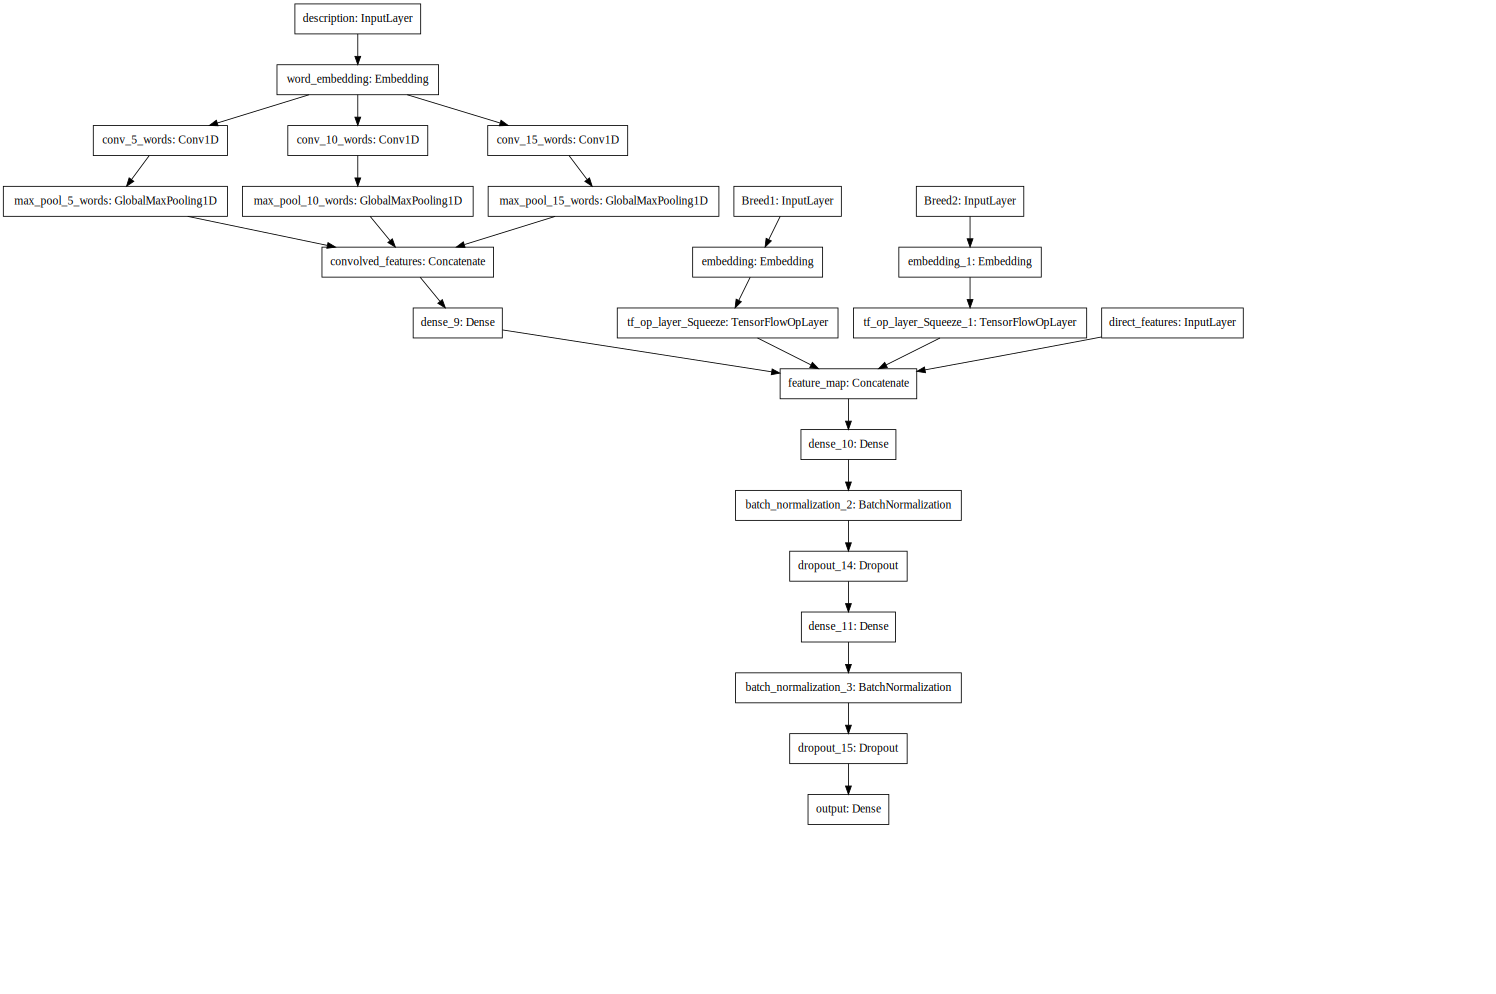

In [0]:
SVG(tf.keras.utils.model_to_dot(model, dpi=60).create(prog='dot', format='svg'))

In [0]:
with mlflow.start_run(nested=True):
      # Log model hiperparameters first
      mlflow.set_tag('ejercicio', '1') 
      mlflow.log_param('description_features_layer_size', DESCRIPTION_FEATURES_LAYER_SIZE)
      mlflow.log_param('hidden_layer_size', HIDDEN_LAYER_SIZE)
      mlflow.log_param('embedded_columns', embedded_columns)
      mlflow.log_param('one_hot_columns', one_hot_columns)
      mlflow.log_param('numerical_columns', numeric_columns)  # Not using these yet
            
      epochs = 10
      history = model.fit(train_dataset, epochs=epochs, validation_data=dev_dataset,
                          verbose=1)
    
      # TODO: analyze history to see if model converges/overfits
      print(history)
      loss, accuracy = 0, 0
      
      loss, accuracy = model.evaluate(dev_dataset, verbose=0)
      print("*** Dev loss: {} - accuracy: {}".format(loss, accuracy))
      mlflow.log_metric('dev-loss', loss)
      mlflow.log_metric('dev-accuracy', accuracy)

      loss, accuracy = model.evaluate(train_dataset, verbose=0)
      print("*** Train loss: {} - accuracy: {}".format(loss, accuracy))
      mlflow.log_metric('train-loss', loss)
      mlflow.log_metric('train-accuracy', accuracy)

      save_history('1', history)



Epoch 1/10
67/67 [==============================] - 37s 559ms/step - loss: 1.9551 - accuracy: 0.2657 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
67/67 [==============================] - 34s 500ms/step - loss: 1.6075 - accuracy: 0.3433 - val_loss: 1.7222 - val_accuracy: 0.3070
Epoch 3/10
67/67 [==============================] - 34s 503ms/step - loss: 1.4485 - accuracy: 0.4067 - val_loss: 1.3459 - val_accuracy: 0.4577
Epoch 4/10
67/67 [==============================] - 34s 505ms/step - loss: 1.3121 - accuracy: 0.4833 - val_loss: 1.2378 - val_accuracy: 0.5295
Epoch 5/10
67/67 [==============================] - 33s 500ms/step - loss: 1.0916 - accuracy: 0.5830 - val_loss: 1.3504 - val_accuracy: 0.5380
Epoch 6/10
67/67 [==============================] - 34s 501ms/step - loss: 0.8462 - accuracy: 0.6890 - val_loss: 2.3914 - val_accuracy: 0.4917
Epoch 7/10
67/67 [==============================] - 34s 501ms/step - loss: 0.7179 - accuracy: 0.7532 - val_loss: 0.8503 - val_accuracy

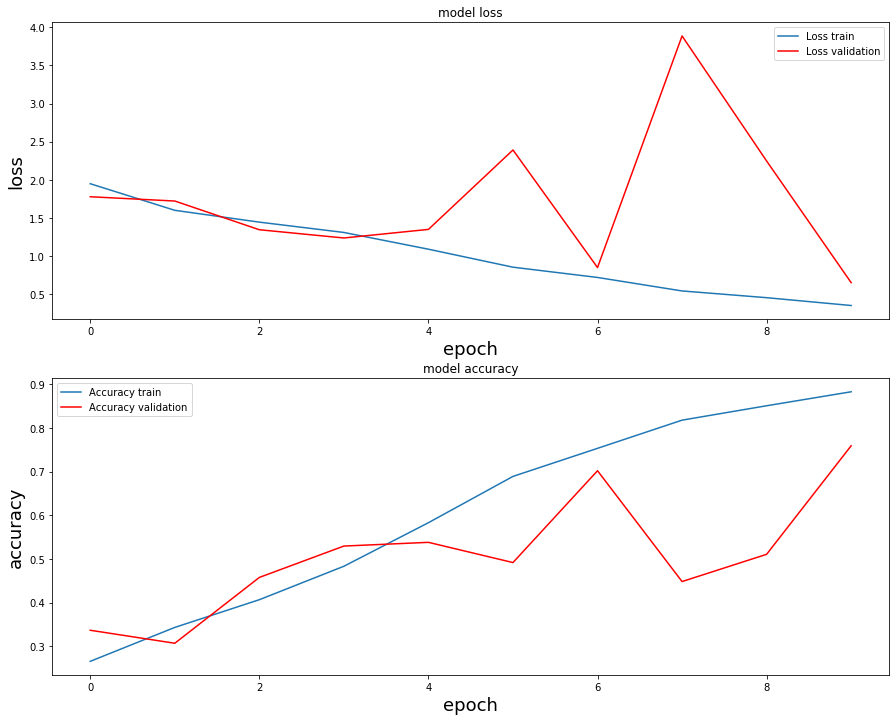

In [0]:
plt.figure(figsize=(15,12))
        
plt.subplot(2,1,1)
plt.plot(history.history['loss'], label='Loss train')
plt.plot(history.history['val_loss'], color='red', label='Loss validation')
plt.title('model loss')
plt.ylabel('loss', size='18')
plt.xlabel('epoch', size='18')
plt.legend()
        
plt.subplot(2,1,2)
plt.plot(history.history['accuracy'], label='Accuracy train')
plt.plot(history.history['val_accuracy'], color='red', label='Accuracy validation')
plt.title('model accuracy')
plt.ylabel('accuracy', size='18')
plt.xlabel('epoch',size='18')
plt.legend()
plt.show()

## Conclusiones


Hemos probado tres modelos cuyas arquitecturas se observan abajo que involucran redes recurrentes, convolucionales y capas densas para manejar los datos de texto en las descripciones. De acuerdo al acurracy y las valores de loss obtenidos el último modelo parece el más apropiado ya que usa redes convolucionales tomando el contexto de cada una de las palabras de la descripción.

### Modelo 1: Arquitectura y resultados

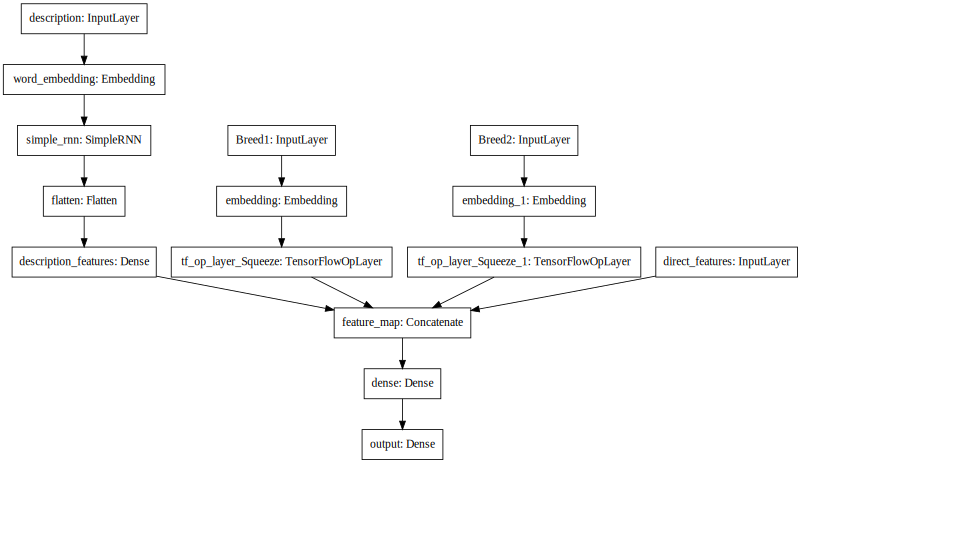

In [0]:
SVG(tf.keras.utils.model_to_dot(model, dpi=60).create(prog='dot', format='svg'))

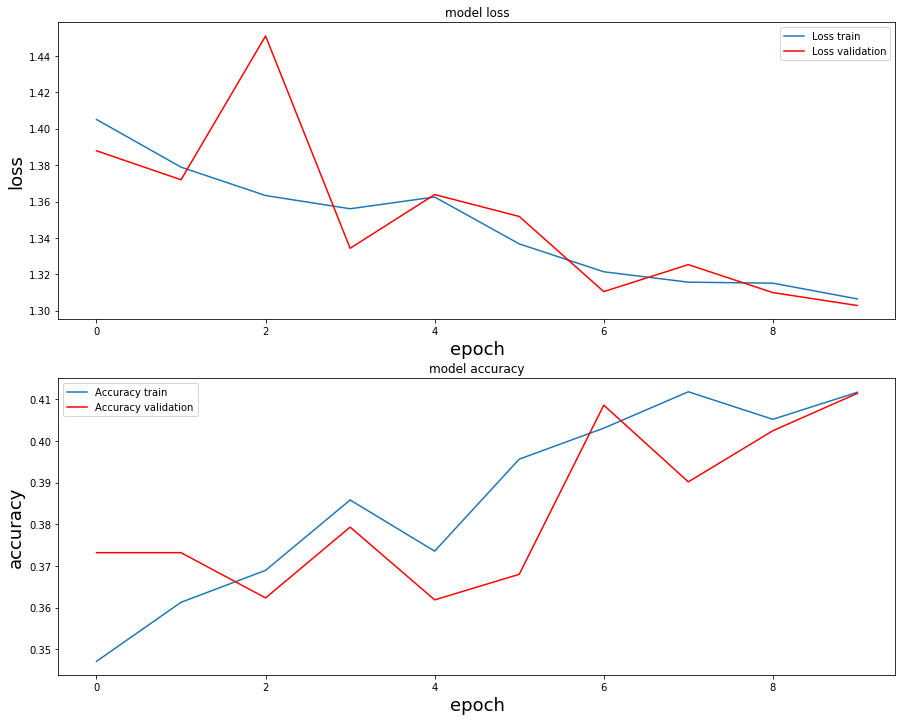


### Modelo 2: arquitectura y resultados

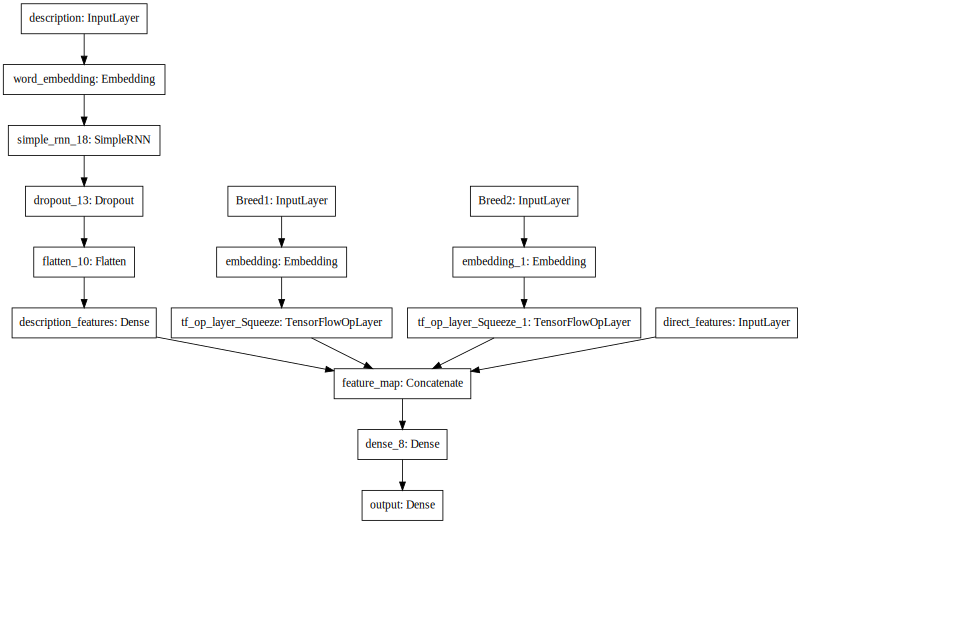

In [0]:
SVG(tf.keras.utils.model_to_dot(model, dpi=60).create(prog='dot', format='svg'))

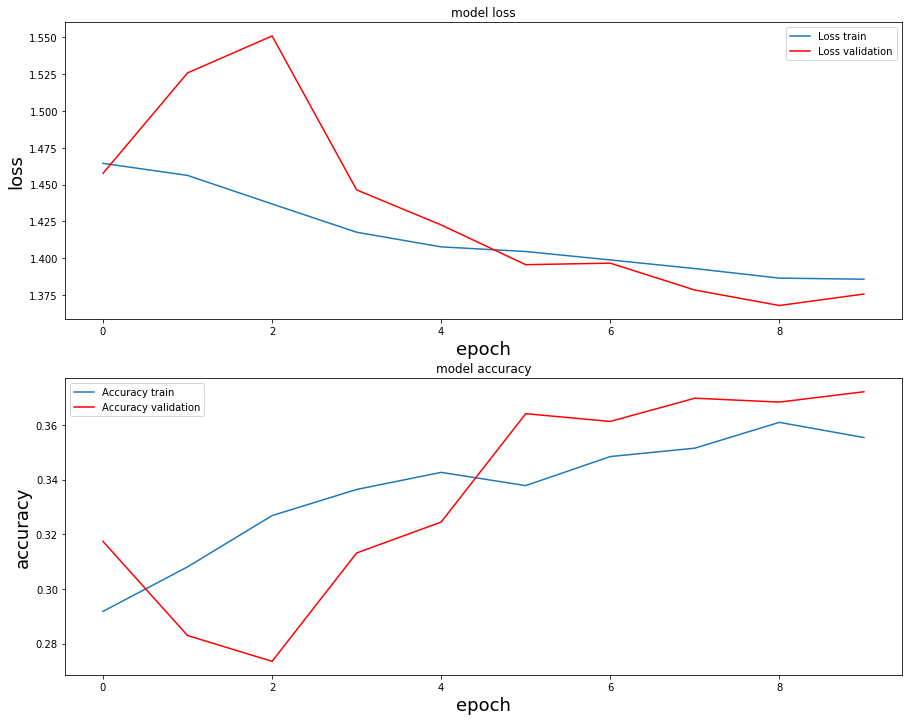

### Modelo 3: Arquitectura y resultados

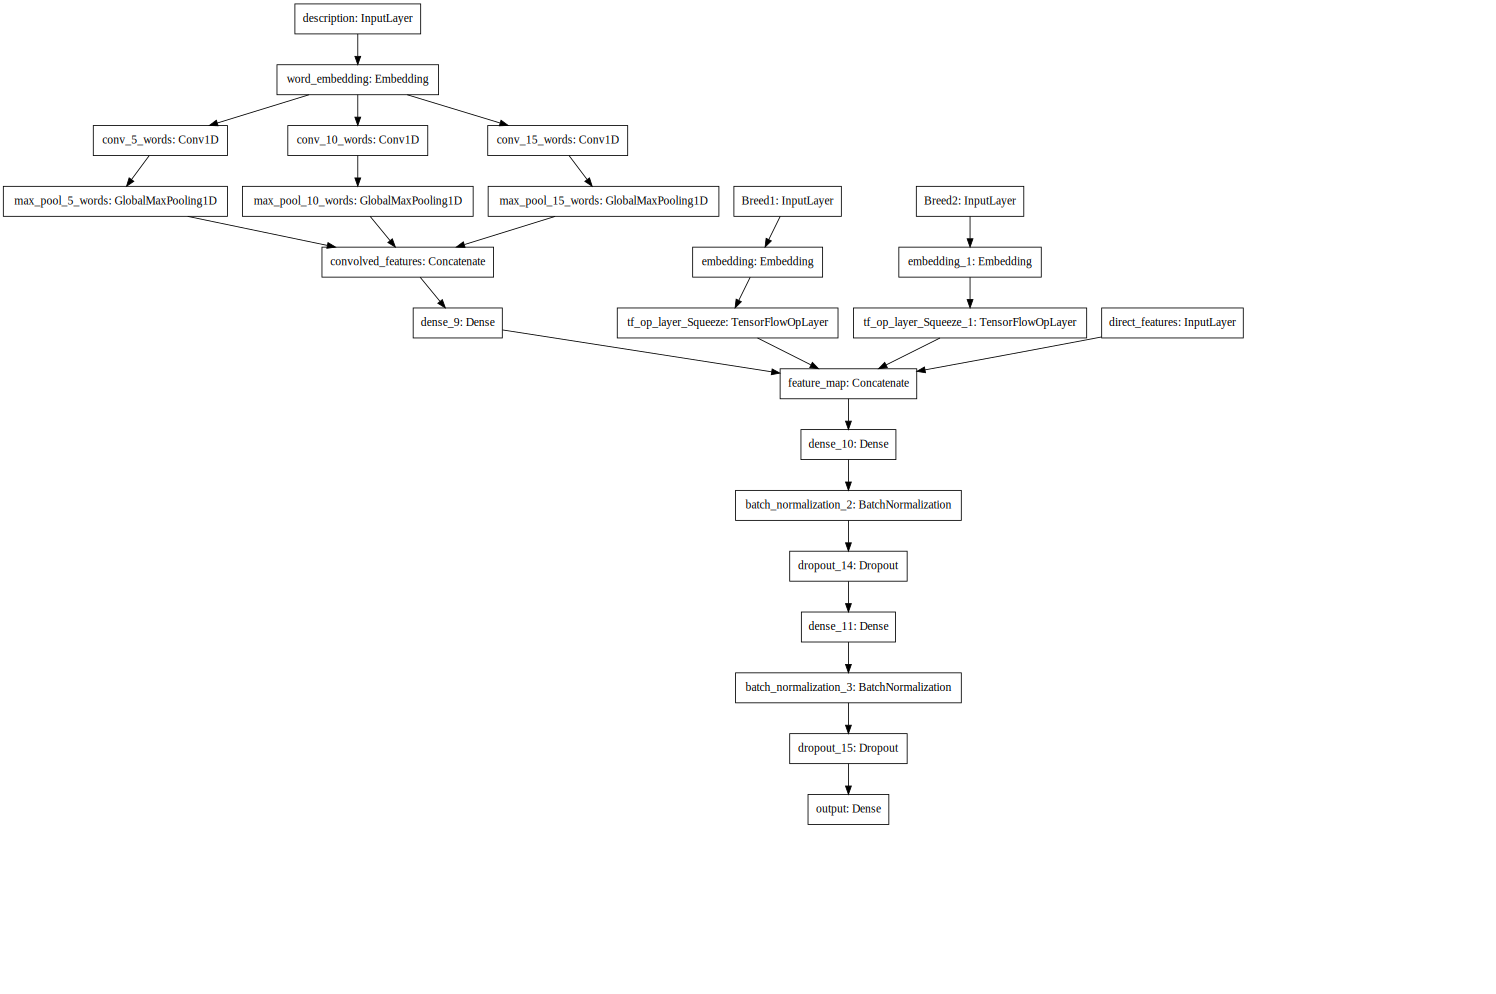

In [0]:
SVG(tf.keras.utils.model_to_dot(model, dpi=60).create(prog='dot', format='svg'))

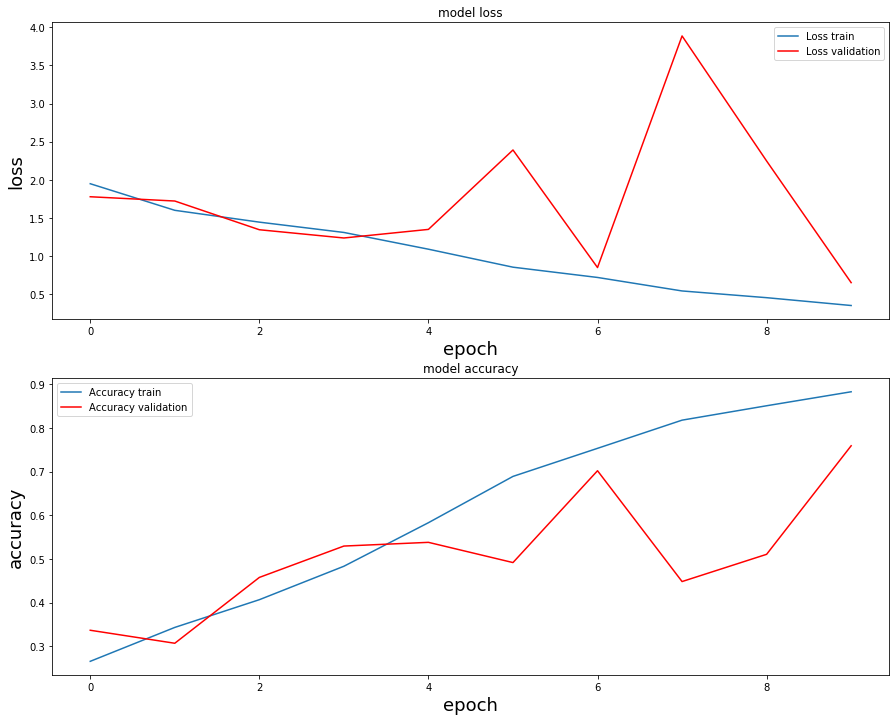